# Import stuff

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import borg
import torch
import time
from map2map_emu.map2map.models.d2d import *
import sys
sys.path.append("/cfs/home/ludo4644/software/")
from cosmo_py import *
import pytest
from jax import vjp
from jax.config import config
config.update("jax_enable_x64", True)
from tqdm import tqdm
from utils.utils import *

def standard_plot(w=10,h=4,fontsize=14):
    fig = plt.figure(figsize=(w,h))
    plt.rcParams.update(plt.rcParamsDefault)
    plt.rcParams.update({'font.size': fontsize})
    plt.rcParams['font.family'] = 'DejaVu Sans'
    #plt.rc('text', usetex=True)
    return plt.gca()


# Memory layout of multi-dimensional arrays (row vs column major)
def compute_displacement(abs_pos, L, Ng, order='F'):
    # Memory layout of multi-dimensional arrays (row vs column major)
    displacement = np.zeros(np.shape(abs_pos))
    initial_pos = np.zeros(np.shape(abs_pos))
    dx = L / Ng

    for i in range(0, Ng):
        for j in range(0, Ng):
            for k in range(0, Ng):
                if order == 'F':
                    n = k + Ng * (j + Ng * i)  # column
                elif order == 'C':
                    n = i + Ng * (j + Ng * k)  # row
                
                qx = i * dx
                qy = j * dx
                qz = k * dx

                initial_pos[n] = [qx, qy, qz]

                displacement[n] = abs_pos[n] - [qx, qy, qz]
                
    return initial_pos, displacement

def check(disp,L,moved_over_bound,max_disp_1d,i,axis):
    idxsup900 = disp[:,i]>moved_over_bound
    idx100 = np.abs(disp[:,i])<max_disp_1d
    idxsubminus900 = disp[:,i]<-moved_over_bound

    sup900 = len(disp[:,i][idxsup900])
    within100 = len(disp[:,i][idx100])
    subminus900 = len(disp[:,i][idxsubminus900])

    print(f'Disp in {axis[i]} direction under -{moved_over_bound} Mpc/h is = ', subminus900)
    print(f'|Disp| in {axis[i]} direction under {max_disp_1d} Mpc/h is = ', within100)
    print(f'Disp in {axis[i]} direction over {moved_over_bound} Mpc/h is = ', sup900)
    print('These add up to: ', subminus900+within100+sup900)
    print('\n')
    
    assert subminus900+within100+sup900 == len(disp[:,i])
    
    return idxsup900, idxsubminus900
    
def correct_displacement_over_periodic_boundaries(disp,L,max_disp_1d=100):
    # Need to correct for positions moving over the periodic boundary

    axis = ['x','y','z']
    moved_over_bound = L - max_disp_1d
    
    for i in [0,1,2]:

        print(f'Before correcting {axis[i]} direction: ')
        print('len(disp[:,i]) = ',len(disp[:,i]))

        idxsup900, idxsubminus900 = check(disp,L,moved_over_bound,max_disp_1d,i,axis)

        # Correct positions
        disp[:,i][idxsup900] -= L
        disp[:,i][idxsubminus900] += L

        print(f'After correcting {axis[i]} direction: ')
        _, _ = check(disp,L,moved_over_bound,max_disp_1d,i,axis)

        assert np.amin(disp[:,i]) >= -max_disp_1d and np.amax(disp[:,i]) <= max_disp_1d
        
    return disp
    
def test_correct_pos(pos,pos_reshaped):
    # The first particle starts at 0,0,0
    # The second particle starts at 0,0,dx
    # The thrid part starts at 0,0,2*dx etc
    tol = 1e-15
    for i in range(0,10):
        assert np.sum(pos[i,:] - pos_reshaped[:,0,0,i]) < tol
        
import numpy as np
from scipy.special import hyp2f1

def dis(x, undo=False, z=0.0, dis_std=6.0, **kwargs):
    dis_norm = dis_std * D(z)  # [Mpc/h]

    if not undo:
        dis_norm = 1 / dis_norm

    x *= dis_norm
    
def vel(x, undo=False, z=0.0, dis_std=6.0, **kwargs):
    vel_norm = dis_std * D(z) * H(z) * f(z) / (1 + z)  # [km/s]

    if not undo:
        vel_norm = 1 / vel_norm

    x *= vel_norm


def D(z, Om=0.31):
    """linear growth function for flat LambdaCDM, normalized to 1 at redshift zero
    """
    OL = 1 - Om
    a = 1 / (1+z)
    return a * hyp2f1(1, 1/3, 11/6, - OL * a**3 / Om) \
             / hyp2f1(1, 1/3, 11/6, - OL / Om)

def f(z, Om=0.31):
    """linear growth rate for flat LambdaCDM
    """
    OL = 1 - Om
    a = 1 / (1+z)
    aa3 = OL * a**3 / Om
    return 1 - 6/11*aa3 * hyp2f1(2, 4/3, 17/6, -aa3) \
                        / hyp2f1(1, 1/3, 11/6, -aa3)

def H(z, Om=0.31):
    """Hubble in [h km/s/Mpc] for flat LambdaCDM
    """
    OL = 1 - Om
    a = 1 / (1+z)
    return 100 * np.sqrt(Om / a**3 + OL)

[INFO   ] libLSS version 972cfd50f1280e1be2cc6fd1595d8669b36e1821 built-in modules Initializing console.

[INFO S ] Registered forward models:
[INFO S ]    2LPT_CIC, 2LPT_CIC_OPENMP, 2LPT_DOUBLE, 2LPT_NGP, ALTAIR_AP, Downgrade
[INFO S ]    EnforceMass, HADES_LOG, HADES_PT, Haar, LPT_CIC, LPT_CIC_OPENMP, LPT_DOUBLE
[INFO S ]    LPT_NGP, LPT_NU_CIC, LPT_NU_CIC_OPENMP, PATCH_MODEL, PM_CIC, PM_CIC_OPENMP
[INFO S ]    PM_CIC_OPENMP2, PRIMORDIAL, PRIMORDIAL_AS, PRIMORDIAL_FNL, QLPT, QLPT_RSD
[INFO S ]    Softplus, TRANSFER_CLASS, TRANSFER_EHU, Transfer, Upgrade, bias::BrokenPowerLaw
[INFO S ]    bias::BrokenPowerLawSigmoid, bias::DoubleBrokenPowerLaw, bias::EFT, bias::EFT_Thresh
[INFO S ]    bias::Linear, bias::ManyPower_1^1, bias::ManyPower_1^2, bias::ManyPower_1^4
[INFO S ]    bias::ManyPower_2^2, bias::Noop, bias::PowerLaw
[INFO S ] Registered forward models (v3):
[INFO S ]    KappaSphere
[INFO S ] Registered likelihoods:
[INFO S ]    BORG_NULL, BORG_POISSON, BORG_REDUCED_SHEAR, BORG_SHEA

In [2]:
class emulator(borg.forward.BaseForwardModel): 
    # Constructor
    def __init__(self, box, prev_module, NN, Om):
        super().__init__(box, box)
        self.prev_module = prev_module
        # Since we won't return an adjoint for the density, but for positions, we need to do:
        self.prev_module.accumulateAdjoint(True)
        self.NN = NN
        self.box = box
        self.Om = Om

    # IO "preferences"
    def getPreferredInput(self):
        return borg.forward.PREFERRED_REAL

    def getPreferredOutput(self):
        return borg.forward.PREFERRED_REAL

    # Forward part
    def forwardModel_v2_impl(self, input_array):
        # Extract particle positions
        pos = np.zeros((self.prev_module.getNumberOfParticles(), 3)) #output shape: (N^3, 3)
        self.prev_module.getParticlePositions(pos)

        # Step 1 - find displacements
        #q, disp = compute_displacement(pos,self.box.L[0], self.box.N[0], order='F') #output shapes: (N^3, 3)
        q = np.load('data/q_initial_L128N250.npy')
        disp = pos - q
        
        # Step 2 - correct for particles that moved over the periodic boundary
        disp_temp = correct_displacement_over_periodic_boundaries(disp,L=self.box.L[0],max_disp_1d=100)
        
        # Step 3 - reshaping initial pos and displacement
        # not sure why order='C' is working here... not sure if it matters... could change it below
        q_reshaped = np.reshape(q.T, (3,self.box.N[0],self.box.N[0],self.box.N[0]), order='C') #output shape: (3, N, N, N)
        dis_in = np.reshape(disp_temp.T, (3,self.box.N[0],self.box.N[0],self.box.N[0]), order='C') #output shape: (3, N, N, N)
        
        # Step 4 - normalize
        print('dis_in[:,0,0,0] = ',dis_in[:,0,0,0])
        dis(dis_in)
        print('dis_in[:,0,0,0] = ',dis_in[:,0,0,0])
        
        # Step 5 - padding to (3,N+48*2,N+48*2,N+48*2)
        print('in_pad shape = ',dis_in.shape)
        dis_in_padded, self.ag_pad = vjp(self.padding, dis_in) #output shape: (3, N+96, N+96, N+96)
        print('out_pad shape = ',np.shape(np.asarray(dis_in_padded)))
        
        # Step 6 - turn into a pytorch tensor (unsquueze because batch = 1)
        self.x = torch.unsqueeze(torch.tensor(np.asarray(dis_in_padded),dtype=torch.float64, requires_grad=True),dim=0) #output shape: (1, 3, N+96, N+96, N+96)
        
        # Step 7 - Pipe through emulator
        self.y = self.NN(self.x,self.Om) #output shape: (1, 3, N, N, N)
        
        # Step 8 - N-body sim displacement 
        dis_out = torch.squeeze(self.y).detach().numpy() #output shape: (3, N, N, N)
        
        # Step 9 - undo the normalization
        print('dis_out[:,0,0,0] = ',dis_out[:,0,0,0])
        dis(dis_out,undo=True)
        print('dis_out[:,0,0,0] = ',dis_out[:,0,0,0])
        
        # Step 10 - convert displacement into positions
        pos = dis_out + q_reshaped
        
        # Step 11 - make sure everything within the box
        pos[pos>self.box.L[0]] -= self.box.L[0]
        pos[pos<0] += self.box.L[0]
        
        # Step 12 - reshape positions 
        print('step12, inshape = ',pos.shape)
        self.pos_out = pos.reshape(3,self.box.N[0]**3,order='C').T #output shape: (N^3, 3)
        print('step12, outshape = ',self.pos_out.shape)
        
    def getDensityFinal_impl(self, output_array):
        output_array[:], self.cic_grad = vjp(lambda x, y, z: jax_cic(x, y, z, *self.box.N + self.box.L),
                                             self.pos_out[:, 0],
                                             self.pos_out[:, 1], 
                                             self.pos_out[:, 2])
        
    # Adjoint part
    def adjointModel_v2_impl(self, input_ag):
        global ag_padded
        # input_ag is the ag of a over-density field
        
        # reverse getDensityFinal
        ag = np.asarray(self.cic_grad(input_ag))
        print('ag_pos_out.shape = ',ag.shape)
        
        # reverse step 11
        ag = np.reshape(ag, (3,self.box.N[0],self.box.N[0],self.box.N[0]), order='C')
        print('ag_pos_out.shape = ',ag.shape)
        
        # reverse step 9
        print('ag_pos_out[:,0,0,0] = ',ag[:,0,0,0])
        dis(ag,undo=False)
        print('ag_pos_out[:,0,0,0] = ',ag[:,0,0,0])
        
        # reverse step 8
        ag = torch.unsqueeze(torch.tensor(ag,dtype=torch.float32),dim=0)
        print('ag_dis_out.shape = ',ag.shape)
        
        # reverse step 7
        ag = torch.autograd.grad(self.y, self.x, grad_outputs=ag, retain_graph=True)[0] #TODO: get rid off retain? , retain_graph=True
        print('ag from NN shape = ',ag.shape)
        
         # reverse step 6
        ag = torch.squeeze(ag).detach().numpy()
        print('ag from NN shape = ',ag.shape)
        
        # reverse step 5
        ag = np.asarray(self.ag_pad(ag))[0] #not sure why adjoint outputs shape (1,3,128,128,128)
        print('ag_padded = ',ag.shape)

        # reverse step 4
        print('ag_padded[:,0,0,0] = ',ag[:,0,0,0])
        dis(ag,undo=True)
        print('ag_padded[:,0,0,0] = ',ag[:,0,0,0])
        
        # reverse step 3
        self.ag_pos = ag.reshape(3,self.box.N[0]**3,order='C').T
        print('self.ag_pos shape = ',self.ag_pos.shape)
        
    def getAdjointModel_impl(self, output_ag):
        # TOASK: do we want this?? will only be the ag for positions
        #print('output_ag.shape = ',output_ag.shape)
        #print('self.ag_pos.shape = ',self.ag_pos.shape)
        #output_ag[:] = np.array(self.ag_pos, dtype=np.float64)
        
        output_ag[:] = 0 
        
        print('Set self.prev_module.adjointModelParticles(ag_pos=np.array(self.ag_pos, dtype=np.float64), ag_vel=np.zeros_like(self.ag_pos, dtype=np.float64)) with self.ag_pos.shape = ',self.ag_pos.shape)
        self.prev_module.adjointModelParticles(ag_pos=np.array(self.ag_pos, dtype=np.float64), ag_vel=np.zeros_like(self.ag_pos, dtype=np.float64))

        
    def padding(self,x):
        return jnp.pad(x,((0,0),(48,48),(48,48),(48,48)),'wrap')
    

# Run forward model

In [3]:
# Initialize some default cosmology
cosmo = borg.cosmo.CosmologicalParameters()
print(cosmo)

L = 1000//4 #boxsize in Mpc/h
Nt = 512//4 #number of part^(1/3)

<CosmologicalParameters: omega_r=0, omega_k=0, omega_m=0.3, omega_b=0.049, omega_q=0.7, w=-1, n_s=1, fnl=0, wprime=0, sigma8=0.8, h=0.8, sum_mnu=0 eV, As=2.3e-09>


In [4]:
np.random.seed(42)
N_v = [Nt,Nt,Nt]
wn_field=np.random.randn(*N_v)
#delta_m, emu_delta_m = test_BORG(L,Nt,wn_field=np.random.randn(*N_v))

In [5]:
def LPT_plus_EMU(L,N,emu=True):

    # setup the box
    bb = borg.forward.BoxModel()
    bb.L = L,L,L
    bb.N = N,N,N

    # Initialize some default cosmology
    cosmo = borg.cosmo.CosmologicalParameters()

    # Fiducial scale factor to express initial conditions
    z_start = 69
    a0 = 1
    nsteps = 20

    chain = borg.forward.ChainForwardModel(bb)

    # Add fluctuations and transfer
    chain.addModel(borg.forward.models.Primordial(bb, a0)) # Add primordial fluctuations    
    chain.addModel(borg.forward.models.EisensteinHu(bb)) # Add E&Hu transfer function

    # Run LPT model from a=0.0 to af. The ai=a0 is the scale factor at which the IC are expressed
    lpt = borg.forward.models.BorgLpt(bb, bb, ai=a0, af=1.0)    
    chain.addModel(lpt)

    # Run all the way from start
    if emu:
        
        # Load weights
        f = '/cfs/home/ludo4644/ML4BORG/map2map_emu/map2map/weights/d2d_weights.pt'
        emu_weights = torch.load(f,map_location=torch.device('cpu'))

        # Initialize model
        model = StyledVNet(1,3,3)
        model.load_state_dict(emu_weights['model'])
        model.double()
        #print('The emulator model has the layers: ', model.eval())

        # Extract omega as style param
        Om = torch.tensor([cosmo.omega_m],dtype=torch.float64) # style parameter
        # from emulator hacking:
        Om -= torch.tensor([0.3])
        Om *= torch.tensor([5.0])

        # Create module in BORG chain
        emu = emulator(bb, lpt, model, Om)

        chain.addModel(emu)
        
        # Set cosmology
        chain.setCosmoParams(cosmo)
        
        return bb, chain, lpt, emu
    
    else:
        
        # Set cosmology
        chain.setCosmoParams(cosmo)
    
        return bb, chain, lpt

def run_chain(bb,chain,wn,lpt=None):
    
    # Generate white noise: it has to be scaled by 1/N**(3./2) to be one in Fourier
    ic = np.fft.rfftn(wn/np.sqrt(Nt**3))
    assert np.std(ic) == pytest.approx(1, rel=1e-3)

    # RUN!
    chain.forwardModel_v2(ic)

    # Get density 
    delta_m = np.zeros(bb.N)
    chain.getDensityFinal(delta_m)
    
    if lpt is None:
        return delta_m
    else:
        # Get pos and vel
        pos = np.zeros((lpt.getNumberOfParticles(),3))
        lpt.getParticlePositions(pos)

        vel = np.zeros((lpt.getNumberOfParticles(),3))
        lpt.getParticleVelocities(vel)

        return delta_m, pos, vel

In [6]:
# Only with LPT
bb, chain, lpt = LPT_plus_EMU(L,Nt,emu=False)
delta_m, pos, vel = run_chain(bb,chain,wn_field, lpt)

# also with EMU
#bb_emu, chain_emu, _, emu = LPT_plus_EMU(L,Nt,emu=True)
#emu_delta_m = run_chain(bb_emu,chain_emu,wn_field)

/cfs/home/ludo4644/.local-co/envs/BORG/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: Call to deprecated class EisensteinHu. (The tailored binding of native forward models are being deprecated in favor of the automatically generated bindings in model_lib)
/cfs/home/ludo4644/.local-co/envs/BORG/lib/python3.7/site-packages/ipykernel_launcher.py:23: DeprecationWarning: Call to deprecated class BorgLpt. (The tailored binding of native forward models are being deprecated in favor of the automatically generated bindings in model_lib)


[STD    ] |     ___________                              
[STD    ] |    /-/_"/-/_/-/|     __________________________ 
[STD    ] |   /"-/-_"/-_//||                BORG3 model
[STD    ] |  /__________/|/|     (c) Jens Jasche 2012 - 2019
[STD    ] |  |"|_'='-]:+|/||        Guilhem Lavaux 2014 - 2019
[STD    ] |  |-+-|.|_'-"||//     __________________________ 
[STD    ] |  |[".[:!+-'=|//     
[STD    ] |  |='!+|-:]|-|/       
[STD    ] |   ----------         
[STD    ] | 
[STD    ] | Please acknowledge the following papers:
[STD    ] |   - Jasche & Lavaux (A&A, 2019, arXiv 1806.11117)
[STD    ] |   - Jasche & Wandelt (MNRAS, 2012, arXiv 1203.3639)
[STD    ] |   - Jasche & Kitaura (MNRAS, 2010, arXiv 0911.2496)
[STD    ] |   - Lavaux, Jasche & Leclercq (arXiV 1909.06396)
[STD    ] |   - And relevant papers depending on the used sub-module/contribution
[STD    ] | 

[STD    ] | This is BORG version 972cfd50f1280e1be2cc6fd1595d8669b36e1821


## Compare LPT with EMU

In [19]:
%matplotlib inline

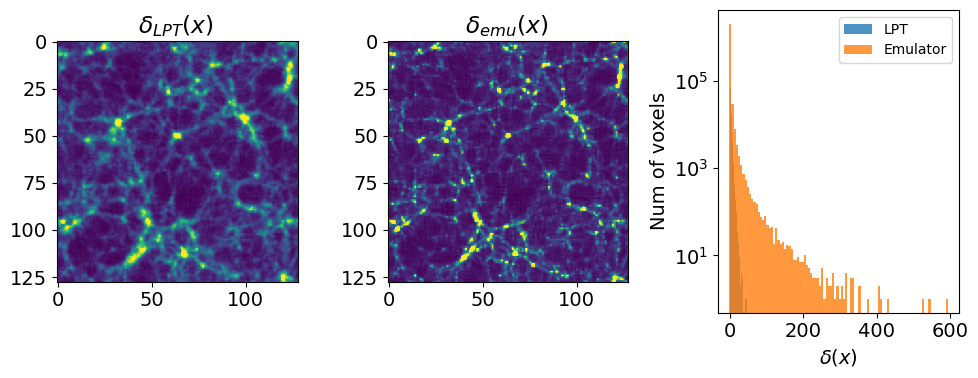

In [21]:
standard_plot(h=4)

plt.subplot(1,3,1)
plt.imshow(np.sum(delta_m[:,:,:10],axis=-1),vmax=50)
plt.title('$\delta_{LPT}(x)$ ')
plt.subplot(1,3,2)
plt.imshow(np.sum(emu_delta_m[:,:,:10]-1,axis=-1),vmax=50)
plt.title('$\delta_{emu}(x)$ ')
plt.tight_layout()
plt.subplot(1,3,3)
plt.hist(delta_m.flatten(),bins=100,label='LPT',alpha=0.8)
plt.hist((emu_delta_m-1).flatten(),bins=100,label='Emulator',alpha=0.8)
#plt.xscale('log')
plt.yscale('log')
plt.xlabel('$\delta(x)$')
plt.ylabel('Num of voxels')
plt.legend(fontsize=10)
plt.tight_layout()
plt.show()

# Tests

## Test adjoint

In [15]:
# test adjoint only for EMU module
ag = np.random.uniform(size=bb.N)
emu.adjointModel_v2(ag)

# No getAdjointModel... wants a (N,N,N)-field but I cannot provide that...
#ag_emu = np.zeros((2097152,3,1))
#ag_emu = np.zeros((128,128,128))
#emu.getAdjointModel(ag_emu)

ag_pos_out.shape =  (3, 2097152)
ag_pos_out.shape =  (3, 128, 128, 128)
ag_pos_out[:,0,0,0] =  [ 0.15595293  0.26559338 -0.0099364 ]
ag_pos_out[:,0,0,0] =  [ 0.02599216  0.04426556 -0.00165607]
ag_dis_out.shape =  torch.Size([1, 3, 128, 128, 128])
ag from NN shape =  torch.Size([1, 3, 224, 224, 224])
ag from NN shape =  (3, 224, 224, 224)
ag_padded =  (3, 128, 128, 128)
ag_padded[:,0,0,0] =  [ 0.0162496   0.02864798 -0.0076878 ]
ag_padded[:,0,0,0] =  [ 0.0974976   0.17188789 -0.04612678]
self.ag_pos shape =  (2097152, 3)


In [16]:
# test adjoint for full chain

dlogL_drho = np.ones(chain_emu.getOutputBoxModel().N)
# Here fill up dlogL_drho from the gradient of the likelihood
chain_emu.adjointModel_v2(dlogL_drho)

ag_pos_out.shape =  (3, 2097152)
ag_pos_out.shape =  (3, 128, 128, 128)
ag_pos_out[:,0,0,0] =  [0. 0. 0.]
ag_pos_out[:,0,0,0] =  [0. 0. 0.]
ag_dis_out.shape =  torch.Size([1, 3, 128, 128, 128])
ag from NN shape =  torch.Size([1, 3, 224, 224, 224])
ag from NN shape =  (3, 224, 224, 224)
ag_padded =  (3, 128, 128, 128)
ag_padded[:,0,0,0] =  [0. 0. 0.]
ag_padded[:,0,0,0] =  [0. 0. 0.]
self.ag_pos shape =  (2097152, 3)
Set self.prev_module.adjointModelParticles(ag_pos=np.array(self.ag_pos, dtype=np.float64), ag_vel=np.zeros_like(self.ag_pos, dtype=np.float64)) with self.ag_pos.shape =  (2097152, 3)


In [20]:
ic = np.ones(chain_emu.getBoxModel().N)
chain_emu.getAdjointModel(ic)

[[[1. 1. 1. ... 1. 1. 1.]
  [1. 1. 1. ... 1. 1. 1.]
  [1. 1. 1. ... 1. 1. 1.]
  ...
  [1. 1. 1. ... 1. 1. 1.]
  [1. 1. 1. ... 1. 1. 1.]
  [1. 1. 1. ... 1. 1. 1.]]

 [[1. 1. 1. ... 1. 1. 1.]
  [1. 1. 1. ... 1. 1. 1.]
  [1. 1. 1. ... 1. 1. 1.]
  ...
  [1. 1. 1. ... 1. 1. 1.]
  [1. 1. 1. ... 1. 1. 1.]
  [1. 1. 1. ... 1. 1. 1.]]

 [[1. 1. 1. ... 1. 1. 1.]
  [1. 1. 1. ... 1. 1. 1.]
  [1. 1. 1. ... 1. 1. 1.]
  ...
  [1. 1. 1. ... 1. 1. 1.]
  [1. 1. 1. ... 1. 1. 1.]
  [1. 1. 1. ... 1. 1. 1.]]

 ...

 [[1. 1. 1. ... 1. 1. 1.]
  [1. 1. 1. ... 1. 1. 1.]
  [1. 1. 1. ... 1. 1. 1.]
  ...
  [1. 1. 1. ... 1. 1. 1.]
  [1. 1. 1. ... 1. 1. 1.]
  [1. 1. 1. ... 1. 1. 1.]]

 [[1. 1. 1. ... 1. 1. 1.]
  [1. 1. 1. ... 1. 1. 1.]
  [1. 1. 1. ... 1. 1. 1.]
  ...
  [1. 1. 1. ... 1. 1. 1.]
  [1. 1. 1. ... 1. 1. 1.]
  [1. 1. 1. ... 1. 1. 1.]]

 [[1. 1. 1. ... 1. 1. 1.]
  [1. 1. 1. ... 1. 1. 1.]
  [1. 1. 1. ... 1. 1. 1.]
  ...
  [1. 1. 1. ... 1. 1. 1.]
  [1. 1. 1. ... 1. 1. 1.]
  [1. 1. 1. ... 1. 1. 1.]]]
[[[0. 0. 0

## Density test (Jens_cic vs jax_cic vs BORG_getDensity)

In [6]:
from jax import vjp
import jax.numpy as jnp
import numpy as np
from utils.utils import *

In [17]:
# Note need to flip positions here...! # Jens implementation .... 
delta_m2 = density(pos[:,2],pos[:,1],pos[:,0],L,N)
delta_m2.shape

cell_len =  1.953125


(128, 128, 128)

In [15]:
delta_m3, cic_grad = vjp(lambda x, y, z: jax_cic(x, y, z, N, N, N, L, L, L), pos[:, 0], pos[:, 1], pos[:, 2])

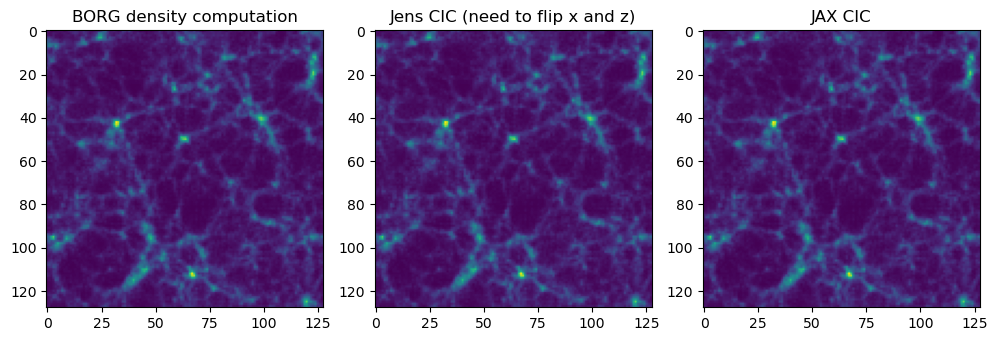

In [21]:
standard_plot(h=8,fontsize=10)

plt.subplot(1,3,1)
plt.imshow(np.sum(delta_m[:,:,:10],axis=-1))
plt.title('BORG density computation')
plt.subplot(1,3,2)
plt.imshow(np.sum(delta_m2[:,:,:10],axis=-1))
plt.title('Jens CIC (need to flip x and z)')
plt.subplot(1,3,3)
plt.imshow(np.sum(delta_m3[:,:,:10],axis=-1))
plt.title('JAX CIC')
plt.tight_layout()
plt.show()

## Gradient test (simple example)

In [289]:
from torch import nn
from torch.nn import functional as F
from torchsummary import summary

class ToyResNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.relu = nn.ReLU()
        self.block1conv1 = nn.Conv3d(1, 32, 3)
        self.block1conv2 = nn.Conv3d(32, 1, 3)
        self.maxpool = nn.MaxPool3d(2)

    def forward(self, x):
        x = self.relu(self.block1conv1(x))
        x = self.relu(self.block1conv2(x))
        x = self.maxpool(x)

        return x

model = ToyResNet()
#summary(model.cuda(),(1,36,36,36))

In [309]:
np.random.seed(42)
in_field = np.random.random((1,16,16,16))
in_true = np.copy(in_field) + np.random.random((1,16,16,16))*1

def padding(x):
    return jnp.pad(x,((0,0),(10,10),(10,10),(10,10)),'wrap')

def add_random(x):
    np.random.seed(1)
    a = 0.1*np.random.random(np.shape(f))
    return jnp.add(x,a)
    
def forward(f,grad=False):
    # Normalize field
    f = f/10
    
    # Add 
    #f += 10 
    #f, ag_add = vjp(add_random, f)
    
    np.random.seed(1) #need this one so that we add the same every time! If we add something different then it won't work
    a = 10*np.random.random(np.shape(f))
    f = f + a
    ag_add=0
    
    # Pad field
    f_out, ag_pad = vjp(padding, f)
    
    # Pipe through NN
    x = torch.unsqueeze(torch.tensor(np.asarray(f_out),dtype=torch.float32, requires_grad=grad),dim=0)
    
    y = model(x)
    out = torch.squeeze(y).detach().numpy()
    
    # Unnormalize field
    out *= 10
    
    return x, y, out, ag_pad, ag_add
    
def loss(out,out_true):
    lo = jnp.sum((out-out_true)**2)
    print('loss = ',lo)
    return lo

# Run forward for truth and a field close to the truth
_, y, out_true, _, _ = forward(in_true)
x, y, out, ag_pad, ag_add = forward(in_field,grad=True)

# Get likelihood/loss
L, agL = vjp(loss,out,out_true)
print(L)

loss =  Traced<ConcreteArray(29.432676315307617, dtype=float32)>with<JVPTrace(level=2/0)> with
  primal = DeviceArray(29.432676, dtype=float32)
  tangent = Traced<ShapedArray(float32[])>with<JaxprTrace(level=1/0)> with
    pval = (ShapedArray(float32[]), *)
    recipe = JaxprEqnRecipe(eqn_id=<object object at 0x7f64a8376650>, invars=(Traced<ShapedArray(float32[16,16,16]):JaxprTrace(level=1/0)>,), outvars=[<weakref at 0x7f64a84472f0; to 'JaxprTracer' at 0x7f64a8447230>], primitive=xla_call, params={'device': None, 'backend': None, 'name': 'jvp(_reduce_sum)', 'donated_invars': (False,), 'inline': True, 'call_jaxpr': { lambda ; a:f32[16,16,16]. let b:f32[] = reduce_sum[axes=(0, 1, 2)] a in (b,) }}, source_info=SourceInfo(traceback=<jaxlib.xla_extension.Traceback object at 0x7f64a8471530>, name_stack=NameStack(stack=(Transform(name='jvp'),))))
29.432676


In [310]:
def finite_diff(in_field,out_true,eps,x0,x1,x2,x3):
    # Copy field
    in_field_epsilon = np.copy(in_field)
    
    # Perturb
    in_field_epsilon[x0,x1,x2,x3] = in_field[x0,x1,x2,x3] + eps
    # Compute likelihood
    _, _, out_eps, _, _ = forward(in_field_epsilon)
    L_eps = loss(out_eps,out_true)
    #print('L = ',L_eps)
    
    # Re-perturb
    in_field_epsilon[x0,x1,x2,x3] = in_field[x0,x1,x2,x3] - eps
    # Recompute
    _, _, out_eps, _, _ = forward(in_field_epsilon)
    L_eps -= loss(out_eps,out_true)
    #print('L = ',L_eps)
    
    # Centered numerical gradient
    QQ = L_eps / (2.0*eps )
    
    return QQ

# Finite diff
eps_v = [0.1,0.01,0.001,0.0001,0.00001,0.000001]
fd_v = []
for eps in eps_v:
    fdtemp = []
    for i in tqdm(range(8)):
        coords = [0,0,0,i]
        fd = finite_diff(in_field,out_true,eps,*coords)
        fdtemp.append(fd)
    fd_v.append(fdtemp)

  0%|                                                                                                                                                                                                                                                   | 0/8 [00:00<?, ?it/s]

loss =  29.45004
loss =  29.417282
loss =  29.425291
loss =  29.441206
loss =  29.448376
loss =  29.418175
loss =  29.443476
loss =  29.42217
loss =  29.436392
loss =  29.42939
loss =  29.44553
loss =  29.422028
loss =  29.44005


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 121.69it/s]


loss =  29.426933
loss =  29.441832
loss =  29.426704


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 129.01it/s]


loss =  29.434313
loss =  29.431053
loss =  29.431871
loss =  29.433464
loss =  29.434147
loss =  29.431177
loss =  29.433727
loss =  29.43161
loss =  29.433077
loss =  29.432287
loss =  29.433872
loss =  29.431532
loss =  29.433355
loss =  29.43207
loss =  29.433443
loss =  29.43194


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 128.88it/s]


loss =  29.432878
loss =  29.432508
loss =  29.432573
loss =  29.432734
loss =  29.432808
loss =  29.432524
loss =  29.432718
loss =  29.432577
loss =  29.432714
loss =  29.432642
loss =  29.432793
loss =  29.43256
loss =  29.432772
loss =  29.432611
loss =  29.43272
loss =  29.432604


  0%|                                                                                                                                                                                                                                                   | 0/8 [00:00<?, ?it/s]

loss =  29.432692
loss =  29.432648
loss =  29.432642
loss =  29.432661


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 121.34it/s]

loss =  29.432697
loss =  29.432627
loss =  29.432663
loss =  29.432648
loss =  29.432673
loss =  29.432638
loss =  29.432661
loss =  29.432634
loss =  29.432653
loss =  29.43267
loss =  29.432663
loss =  29.432657



  0%|                                                                                                                                                                                                                                                   | 0/8 [00:00<?, ?it/s]

loss =  29.43268
loss =  29.432673
loss =  29.432665
loss =  29.432663
loss =  29.432674


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 123.81it/s]


loss =  29.43266
loss =  29.432663
loss =  29.432676
loss =  29.432669
loss =  29.432676
loss =  29.43266
loss =  29.432669
loss =  29.432674
loss =  29.432661
loss =  29.432673
loss =  29.432657


  0%|                                                                                                                                                                                                                                                   | 0/8 [00:00<?, ?it/s]

loss =  29.432676
loss =  29.432676
loss =  29.432676
loss =  29.432676
loss =  29.432676
loss =  29.432676
loss =  29.432676
loss =  29.432676
loss =  29.432676
loss =  29.432676


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 126.92it/s]

loss =  29.432673
loss =  29.432676
loss =  29.432676
loss =  29.432684
loss =  29.432676
loss =  29.432676


In [311]:
# Analytical: get everything for full field directly

ag = torch.unsqueeze(torch.unsqueeze(torch.tensor(np.asarray(agL(1.))[0]),dim=0),dim=0)
ag /= 10
ag = torch.autograd.grad(y, x, grad_outputs=ag, retain_graph=True)[0] 
ag = ag_pad(torch.squeeze(ag,dim=0).detach().numpy())
ag = np.squeeze(ag)
#ag = ag_add(np.expand_dims(ag,axis=0))
#ag = np.squeeze(ag)
ag *= 10
analytical_grad = []
for i in tqdm(range(8)):
    analytical_grad.append(ag[0,0,i])

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 153216.58it/s]


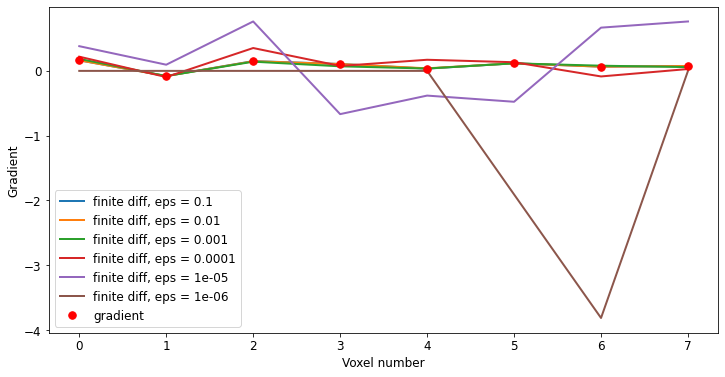

In [312]:
# Plot diff btw gradient and finite difference 

%matplotlib inline
standard_plot(w=12,h=6,fontsize=12)
for i,fd in enumerate(fd_v):
    plt.plot(fd,'-',lw=2,label=f'finite diff, eps = {eps_v[i]}')
plt.plot(analytical_grad,'.',c='r',markersize=15,label='gradient')
plt.xlabel('Voxel number')
plt.ylabel('Gradient')
plt.legend()
plt.show()

## Gradient test (on my module)

In [70]:
def compute_displacement(abs_pos, L, Ng, order='F'):
    # Memory layout of multi-dimensional arrays (row vs column major)
    displacement = np.zeros(np.shape(abs_pos))
    initial_pos = np.zeros(np.shape(abs_pos))
    dx = L / Ng
    n_temp = -1 

    for i in range(0, Ng):
        for j in range(0, Ng):
            for k in range(0, Ng):
                
                if order == 'F':
                    n = k + Ng * (j + Ng * i)  # column
                elif order == 'C':
                    n = i + Ng * (j + Ng * k)  # row
                
                qx = i * dx
                qy = j * dx
                qz = k * dx

                initial_pos[n] = [qx, qy, qz]

                displacement[n] = abs_pos[n] - [qx, qy, qz]
                
                if n-n_temp == 1:
                    pass
                else:
                    print(n)
                n_temp = n
                
    return initial_pos, displacement

q, _ = compute_displacement(np.copy(pos), L, N, order='F')
np.save('data/q_initial_L128N250',q)

In [37]:
q_initial = np.load('data/q_initial_L128N250.npy')
dis128_in = np.load('map2map_emu/LPT128_seed42_dis_in.npy')

In [27]:
def padding(x):
        return jnp.pad(x,((0,0),(48,48),(48,48),(48,48)),'wrap')

def forward_my_module_2(pos,q,L,N,NN,Om,requires_grad=True):
     
    return 0, 0, output_array, 0,0
    
def forward_my_module_2(pos,q,L,N,NN,Om,requires_grad=True):
    torch.cuda.empty_cache()
    
    # Step 1 - find displacements
    #q, disp = compute_displacement(pos,L,N, order='F') #output shapes: (N^3, 3)
    disp = pos - q
    
    # Step 2 - correct for particles that moved over the periodic boundary
    disp_temp = correct_displacement_over_periodic_boundaries(disp,L=L,max_disp_1d=100)
    
    # Step 3 - reshaping initial pos and displacement
    # not sure why order='C' is working here... not sure if it matters... could change it below
    q_reshaped = np.reshape(q.T, (3,N,N,N), order='C') #output shape: (3, N, N, N)
    dis_in = np.reshape(disp_temp.T, (3,N,N,N), order='C') #output shape: (3, N, N, N)
    
    # Step 4 - normalize
    print('dis_in[:,0,0,0] = ',dis_in[:,0,0,0])
    print('dis_in[:,100,100,100] = ',dis_in[:,100,100,100])
    dis(dis_in)
    print('dis_in[:,0,0,0] = ',dis_in[:,0,0,0])
    print('dis_in[:,100,100,100] = ',dis_in[:,100,100,100])
    
    # Step 5 - padding to (3,N+48*2,N+48*2,N+48*2)
    print('in_pad shape = ',dis_in.shape)
    dis_in_padded, ag_pad = vjp(padding, dis_in) #output shape: (3, N+96, N+96, N+96)
    print('out_pad shape = ',np.shape(np.asarray(dis_in_padded)))
    print('dis_in_padded.dtype = ',dis_in_padded.dtype)
    
    # Step 6 - turn into a pytorch tensor (unsquueze because batch = 1)
    x = torch.unsqueeze(torch.tensor(np.asarray(dis_in_padded),dtype=torch.float32, requires_grad=requires_grad),dim=0) #output shape: (1, 3, N+96, N+96, N+96)
    #x = torch.tensor(np.asarray(dis_in_padded),dtype=torch.float32, requires_grad=requires_grad) #output shape: (1, 3, N+96, N+96, N+96)
    print(Om.dtype)
    print(x.dtype)
    print(x.shape)
    print(x.size())
    
    # Step 7 - Pipe through emulator
    y = NN(x,Om) #output shape: (1, 3, N, N, N)
    print(y.dtype)
    
    # Step 8 - N-body sim displacement 
    dis_out = torch.squeeze(y).detach().numpy() #output shape: (3, N, N, N)
    print(dis_out.dtype)
    dis_out = dis_out.astype(np.float64)
    print(dis_out.dtype)
    #dis_out = dis_in
    
    # Step 9 - undo the normalization
    print('dis_out[:,0,0,0] = ',dis_out[:,0,0,0])
    print('dis_out[:,100,100,100] = ',dis_out[:,100,100,100])
    dis(dis_out,undo=True)
    print('dis_out[:,0,0,0] = ',dis_out[:,0,0,0])
    print('dis_out[:,100,100,100] = ',dis_out[:,100,100,100])
    
    # Step 10 - convert displacement into positions
    pos = dis_out + q_reshaped
    
    # Step 11 - make sure everything within the box
    print('np.sum(np.ones(np.shape(pos))[pos>L]) = ',np.sum(np.ones(np.shape(pos))[pos>L]))
    print('np.sum(np.ones(np.shape(pos))[pos<0]) = ',np.sum(np.ones(np.shape(pos))[pos<0]))
    inddd = pos>L
    print('pos[pos>L] = ',pos[pos>L])
    pos[pos>L] -= L
    print('pos[inddd] = ',pos[inddd])
    pos[pos<0] += L
    
    # Step 12 - reshape positions 
    print('step12, inshape = ',pos.shape)
    pos_out = np.reshape(pos,(3,N**3),order='C').T #output shape: (N^3, 3)
    print('step12, outshape = ',pos_out.shape)
    
    output_array, cic_grad = vjp(lambda x, y, z: jax_cic(x, y, z, *[N,N,N] + [L,L,L]),
                                    pos_out[:, 0],
                                    pos_out[:, 1], 
                                    pos_out[:, 2])

    return ag_pad, cic_grad, output_array, x, y
    
def loss(out,out_true):
    #return jnp.sum((out)**2) 
    return jnp.sum((out-out_true)**2)


In [30]:
# Load weights
f = '/cfs/home/ludo4644/ML4BORG/map2map_emu/map2map/weights/d2d_weights.pt'
emu_weights = torch.load(f,map_location=torch.device('cpu'))

model = 0
# Initialize model
model = StyledVNet(1,3,3)
model.load_state_dict(emu_weights['model'])
#model.double()
#print('The emulator model has the layers: ', model.eval())

# Extract omega as style param
Om = torch.tensor([cosmo.omega_m],dtype=torch.float32) # style parameter
# from emulator hacking:
Om -= torch.tensor([0.3])
Om *= torch.tensor([5.0])

L, N = 250, 128
q = np.load('data/q_initial_L128N250.npy')

# Create test and true data 
np.random.seed(42)
pos_true = np.copy(pos) 
perturb = 0.00001
pos_test = np.copy(pos) + perturb*np.random.random(np.shape(pos))

# Run forward
_, _, output_true, _, _ = forward_my_module(pos_true,q,L,N,model,Om,requires_grad=False)
ag_pad, cic_grad, output_array, x, y = forward_my_module(pos_test,q,L,N,model,Om)

# Get likelihood/loss
Loss, agL = vjp(loss,output_array,output_true)
print(Loss)
print(agL(1.0))

Before correcting x direction: 
len(disp[:,i]) =  2097152
Disp in x direction under -150 Mpc/h is =  9133
|Disp| in x direction under 100 Mpc/h is =  2056112
Disp in x direction over 150 Mpc/h is =  31907
These add up to:  2097152


After correcting x direction: 
Disp in x direction under -150 Mpc/h is =  0
|Disp| in x direction under 100 Mpc/h is =  2097152
Disp in x direction over 150 Mpc/h is =  0
These add up to:  2097152


Before correcting y direction: 
len(disp[:,i]) =  2097152
Disp in y direction under -150 Mpc/h is =  6851
|Disp| in y direction under 100 Mpc/h is =  2059141
Disp in y direction over 150 Mpc/h is =  31160
These add up to:  2097152


After correcting y direction: 
Disp in y direction under -150 Mpc/h is =  0
|Disp| in y direction under 100 Mpc/h is =  2097152
Disp in y direction over 150 Mpc/h is =  0
These add up to:  2097152


Before correcting z direction: 
len(disp[:,i]) =  2097152
Disp in z direction under -150 Mpc/h is =  14781
|Disp| in z direction under 1

In [14]:
torch.cuda.empty_cache()
torch.cuda.memory_allocated()
torch.cuda.reset_max_memory_allocated()

/cfs/home/ludo4644/.local-co/envs/BORG/lib/python3.7/site-packages/torch/cuda/memory.py:263: FutureWarning: torch.cuda.reset_max_memory_allocated now calls torch.cuda.reset_peak_memory_stats, which resets /all/ peak memory stats.
  FutureWarning)


In [ ]:
# WHY ARE 250.51511442 250.3914879  250.0209202  ... 252.42563108 252.95651037
#  250.08396323 SOME VALUES GOING OVER THE BOUNDARY?? 

print(pos[10:11,:])
print(output_true[10:11,:])
print(output_array[10:11,:])

In [509]:
pos[500000,:]

array([ 64.4110591 , 129.4194391 ,  62.66982106])

In [33]:
def finite_diff(pos_in,q,out_true,eps,L,N,model,Om,part,coord):
    # Copy field
    pos_in_epsilon = np.copy(pos_in)
    
    # Perturb
    pos_in_epsilon[part,coord] = pos_in[part,coord] + eps
    # Compute likelihood
    _, _, out_eps, _, _ = forward_my_module(pos_in_epsilon,q,L,N,model,Om,requires_grad=False)
    L_eps = loss(out_eps,out_true)
    #print('L = ',L_eps)
    
    # Re-perturb
    pos_in_epsilon[part,coord] = pos_in[part,coord] - eps
    # Recompute
    _, _, out_eps, _, _= forward_my_module(pos_in_epsilon,q,L,N,model,Om,requires_grad=False)
    L_eps -= loss(out_eps,out_true)
    print('L = ',L_eps)
    
    # Centered numerical gradient
    QQ = L_eps / (2.0*eps)
    
    return QQ

# Finite diff
eps_v = [0.0001]
fd_v = []
for eps in eps_v:
    fdtemp = []
    for i in tqdm(range(0,0+2)):
        print(i)
        coords = [i,0]
        fd = finite_diff(pos_test,q,output_true,eps,L,N,model,Om,*coords)
        fdtemp.append(fd)
    fd_v.append(fdtemp)

  0%|                                                                                                                                                                                 | 0/2 [00:00<?, ?it/s]

0
Before correcting x direction: 
len(disp[:,i]) =  2097152
Disp in x direction under -150 Mpc/h is =  9133
|Disp| in x direction under 100 Mpc/h is =  2056112
Disp in x direction over 150 Mpc/h is =  31907
These add up to:  2097152


After correcting x direction: 
Disp in x direction under -150 Mpc/h is =  0
|Disp| in x direction under 100 Mpc/h is =  2097152
Disp in x direction over 150 Mpc/h is =  0
These add up to:  2097152


Before correcting y direction: 
len(disp[:,i]) =  2097152
Disp in y direction under -150 Mpc/h is =  6851
|Disp| in y direction under 100 Mpc/h is =  2059141
Disp in y direction over 150 Mpc/h is =  31160
These add up to:  2097152


After correcting y direction: 
Disp in y direction under -150 Mpc/h is =  0
|Disp| in y direction under 100 Mpc/h is =  2097152
Disp in y direction over 150 Mpc/h is =  0
These add up to:  2097152


Before correcting z direction: 
len(disp[:,i]) =  2097152
Disp in z direction under -150 Mpc/h is =  14781
|Disp| in z direction under

 50%|████████████████████████████████████████████████████████████████████████████████████▌                                                                                    | 1/2 [00:18<00:18, 18.98s/it]

L =  3.148244222825683e-09
1
Before correcting x direction: 
len(disp[:,i]) =  2097152
Disp in x direction under -150 Mpc/h is =  9133
|Disp| in x direction under 100 Mpc/h is =  2056112
Disp in x direction over 150 Mpc/h is =  31907
These add up to:  2097152


After correcting x direction: 
Disp in x direction under -150 Mpc/h is =  0
|Disp| in x direction under 100 Mpc/h is =  2097152
Disp in x direction over 150 Mpc/h is =  0
These add up to:  2097152


Before correcting y direction: 
len(disp[:,i]) =  2097152
Disp in y direction under -150 Mpc/h is =  6851
|Disp| in y direction under 100 Mpc/h is =  2059141
Disp in y direction over 150 Mpc/h is =  31160
These add up to:  2097152


After correcting y direction: 
Disp in y direction under -150 Mpc/h is =  0
|Disp| in y direction under 100 Mpc/h is =  2097152
Disp in y direction over 150 Mpc/h is =  0
These add up to:  2097152


Before correcting z direction: 
len(disp[:,i]) =  2097152
Disp in z direction under -150 Mpc/h is =  14781


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:37<00:00, 18.95s/it]

L =  9.265066358581011e-07


In [31]:
# Analytical... 
input_ag = torch.unsqueeze(torch.unsqueeze(torch.tensor(np.asarray(agL(1.))[0]),dim=0),dim=0)
print(input_ag.shape)
ag = torch.squeeze(input_ag).detach().numpy()
print(ag.shape)

# reverse getDensityFinal
ag = np.asarray(cic_grad(ag))
print('ag_pos_out.shape = ',ag.shape)

# reverse step 11
ag = np.reshape(ag, (3,N,N,N), order='C')
print('ag_pos_out.shape = ',ag.shape)
#print(ag)

# reverse step 9
print('ag_pos_out[:,0,0,0] = ',ag[:,0,0,0])
dis(ag,undo=False)
print('ag_pos_out[:,0,0,0] = ',ag[:,0,0,0])

#"""
# reverse step 8
ag = torch.unsqueeze(torch.tensor(ag,dtype=torch.float32),dim=0)
print('ag_dis_out.shape = ',ag.shape)

# reverse step 7
ag = torch.autograd.grad(y, x, grad_outputs=ag, retain_graph=True)[0] 
print('ag from NN shape = ',ag.shape)

# reverse step 6
ag = torch.squeeze(ag).detach().numpy()
print('ag from NN shape = ',ag.shape)

ag = ag.astype(np.float64)

# reverse step 5
ag = np.asarray(ag_pad(ag))[0] #not sure why adjoint outputs shape (1,3,128,128,128)
print('ag_padded = ',ag.shape)
#"""

# reverse step 4
print('ag_padded[:,0,0,0] = ',ag[:,0,0,0])
dis(ag,undo=True)
print('ag_padded[:,0,0,0] = ',ag[:,0,0,0])

# reverse step 3
ag = np.reshape(ag,(3,N**3),order='C').T
print('self.ag_pos shape = ',ag.shape)

torch.Size([1, 1, 128, 128, 128])
(128, 128, 128)
ag_pos_out.shape =  (3, 2097152)
ag_pos_out.shape =  (3, 128, 128, 128)
ag_pos_out[:,0,0,0] =  [-2.73657539e-05 -7.37229506e-05  3.29346556e-05]
ag_pos_out[:,0,0,0] =  [-4.56095898e-06 -1.22871584e-05  5.48910927e-06]
ag_dis_out.shape =  torch.Size([1, 3, 128, 128, 128])
ag from NN shape =  torch.Size([1, 3, 224, 224, 224])
ag from NN shape =  (3, 224, 224, 224)
ag_padded =  (3, 128, 128, 128)
ag_padded[:,0,0,0] =  [1.29335132e-05 1.63266336e-05 1.51094507e-05]
ag_padded[:,0,0,0] =  [7.76010791e-05 9.79598017e-05 9.06567043e-05]
self.ag_pos shape =  (2097152, 3)


In [32]:
analytical_grad = []
for i in tqdm(range(0,0+10)):
    analytical_grad.append(ag[i,0])
print(analytical_grad)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 135300.13it/s]

[7.760107905596669e-05, 0.00022205475227110583, 0.0002832461382240581, 0.00033978341667761924, 0.0003093966537903725, 0.00021048535654699663, -0.00011916245679799431, 0.00012388955840947347, 8.954292053431345e-05, 8.216635836788555e-05]


In [34]:
print(np.asarray(fd_v))

[[1.57412211e-05 4.63253318e-03]]


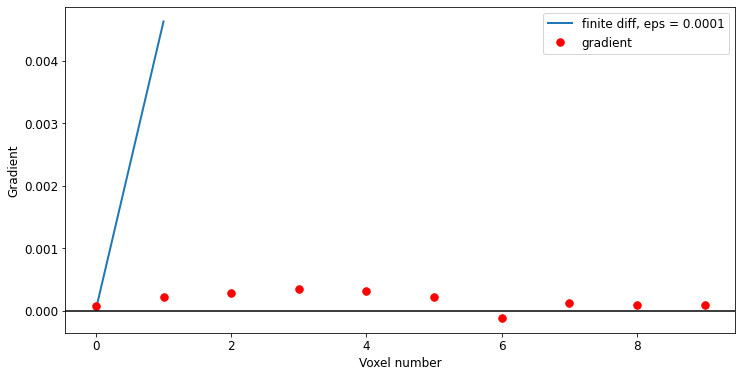

In [35]:
# Plot diff btw gradient and finite difference 

%matplotlib inline
standard_plot(w=12,h=6,fontsize=12)
for i,fd in enumerate(fd_v):
    plt.plot(fd,'-',lw=2,label=f'finite diff, eps = {eps_v[i]}')
plt.plot(analytical_grad,'.',c='r',markersize=15,label='gradient')
plt.xlabel('Voxel number')
plt.ylabel('Gradient')
ax=plt.gca()
ax.axhline(0,c='k')
plt.legend()
plt.show()

In [515]:
print(pos[0:0+40,0])

[249.02177256 248.86040016 249.54029995 249.26010686   0.67197647
   0.28164838   2.67760504   4.98719064   5.89611981   6.47289703
   4.39214213   2.24148255   3.15589964   5.83574142   8.61545406
   8.71884229   7.84707438   7.08009158   6.52109437   6.42912916
   4.74345297   2.78302949   1.35064047   0.97575618 249.53893425
 248.14298147 246.98016624 246.19295725 246.88209937 247.14749556
 248.51889959 249.00806278 249.12198969   1.10346182   0.94729111
   2.05369203   5.32214858   6.1196732    5.45163262   4.60953401]


In [297]:
print_gpu_utilization()

NameError: name 'print_gpu_utilization' is not defined

### Only test NN-model

In [19]:
# Load weights
f = '/cfs/home/ludo4644/ML4BORG/map2map_emu/map2map/weights/d2d_weights.pt'
emu_weights = torch.load(f,map_location=torch.device('cpu'))

model = 0
# Initialize model
model = StyledVNet(1,3,3)
model.load_state_dict(emu_weights['model'])
model.double()
#print('The emulator model has the layers: ', model.eval())

# Extract omega as style param
Om = torch.tensor([cosmo.omega_m],dtype=torch.float32) # style parameter
# from emulator hacking:
Om -= torch.tensor([0.3])
Om *= torch.tensor([5.0])

L, N = 250, 128
q = np.load('data/q_initial_L128N250.npy')
dis128_in = np.load('map2map_emu/LPT128_seed42_dis_in.npy')

def padding(x):
        return jnp.pad(x,((0,0),(48,48),(48,48),(48,48)),'wrap')


dis_in_padded128, ag_pad = vjp(padding, dis128_in) #output shape: (3, N+96, N+96, N+96)
dis_in_padded128.shape

# Create test and true data 
np.random.seed(42)
pos_true = np.copy(dis_in_padded128) 
perturb = 0.001
pos_test = np.copy(dis_in_padded128) + perturb*np.random.random(np.shape(dis_in_padded128))


def loss(out,out_true):
    #return jnp.sum((out)**2) 
    return jnp.sum((out-out_true)**2)

def forward_my_module(dis_in_padded,NN,Om,requires_grad=False):
    print('hej')
    print(dis_in_padded.shape)
    x = torch.unsqueeze(torch.tensor(np.asarray(dis_in_padded),dtype=torch.float64, requires_grad=requires_grad),dim=0) #output shape: (1, 3, N+96, N+96, N+96)
    y = NN(x,Om)
    dis_out = torch.squeeze(y).detach().numpy()
    print(dis_out.shape)
    return x, y, dis_out
    
# Run forward
x,y,output_true = forward_my_module(pos_true,model,Om)
x,y,output_array = forward_my_module(pos_test,model,Om,requires_grad=False)

# Get likelihood/loss
Loss, agL = vjp(loss,output_array,output_true)
print(type(np.asarray(Loss)))
print(Loss)


hej
(3, 224, 224, 224)


RuntimeError: [enforce fail at CPUAllocator.cpp:71] . DefaultCPUAllocator: can't allocate memory: you tried to allocate 147197952000 bytes. Error code 12 (Cannot allocate memory)

In [17]:
def get_n_params(model):
    pp=0
    for p in list(model.parameters()):
        nn=1
        for s in list(p.size()):
            nn = nn*s
        pp += nn
    return pp

pp = get_n_params(model)
print(pp)

3352210


In [159]:
def finite_diff(pos_in,q,out_true,eps,L,N,model,Om,part,coord0,coord1,coord2):
    # Copy field
    pos_in_epsilon = np.copy(pos_in)
    
    # Perturb
    pos_in_epsilon[part,coord0,coord1,coord2] = pos_in[part,coord0,coord1,coord2] + eps
    # Compute likelihood
    _, _, out_eps = forward_my_module(pos_in_epsilon,model,Om)
    L_eps = loss(out_eps,out_true)
    #print('L = ',L_eps)
    
    # Re-perturb
    pos_in_epsilon[part,coord0,coord1,coord2] = pos_in[part,coord0,coord1,coord2] - eps
    # Recompute
    _, _, out_eps = forward_my_module(pos_in_epsilon,model,Om)
    L_eps -= loss(out_eps,out_true)
    print('L = ',L_eps)
    
    # Centered numerical gradient
    QQ = np.asarray(L_eps) / (2.0*eps)
    
    print(type(QQ))
    
    return QQ

# Finite diff
eps_v = [0.1,0.001]
fd_v = []
for eps in eps_v:
    fdtemp = []
    for i in tqdm(range(0,0+10)):
        print(i)
        coords = [0,i,0,0]
        fd = finite_diff(pos_test,q,output_true,eps,L,N,model,Om,*coords)
        fdtemp.append(fd)
    fd_v.append(fdtemp)

  0%|                                                                                                                                                                                | 0/10 [00:00<?, ?it/s]

0
hej
hej


 10%|████████████████▊                                                                                                                                                       | 1/10 [00:08<01:20,  8.96s/it]

L =  -1.8319026851010278e-13
<class 'numpy.float64'>
1
hej
hej


 20%|█████████████████████████████████▌                                                                                                                                      | 2/10 [00:16<01:05,  8.16s/it]

L =  -1.0682080220369983e-13
<class 'numpy.float64'>
2
hej
hej


 30%|██████████████████████████████████████████████████▍                                                                                                                     | 3/10 [00:26<01:01,  8.79s/it]

L =  2.140419785856551e-12
<class 'numpy.float64'>
3
hej
hej
L =  1.7667013685329636e-12
<class 'numpy.float64'>


 40%|███████████████████████████████████████████████████████████████████▏                                                                                                    | 4/10 [00:33<00:49,  8.32s/it]

4
hej
hej


 50%|████████████████████████████████████████████████████████████████████████████████████                                                                                    | 5/10 [00:42<00:42,  8.41s/it]

L =  3.982578156147554e-12
<class 'numpy.float64'>
5
hej
hej


 60%|████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                   | 6/10 [00:50<00:33,  8.29s/it]

L =  -1.007911809569606e-11
<class 'numpy.float64'>
6
hej
hej


 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                  | 7/10 [00:58<00:24,  8.25s/it]

L =  -4.7063575259187473e-11
<class 'numpy.float64'>
7
hej
hej


 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                 | 8/10 [01:08<00:17,  8.65s/it]

L =  -8.714778898522013e-12
<class 'numpy.float64'>
8
hej
hej
L =  2.9217222391464404e-11
<class 'numpy.float64'>


 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                | 9/10 [01:15<00:08,  8.33s/it]

9
hej
hej


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [01:24<00:00,  8.45s/it]


L =  2.137427387860491e-11
<class 'numpy.float64'>


  0%|                                                                                                                                                                                | 0/10 [00:00<?, ?it/s]

0
hej
hej


 10%|████████████████▊                                                                                                                                                       | 1/10 [00:07<01:11,  7.92s/it]

L =  -1.8006429680639258e-15
<class 'numpy.float64'>
1
hej
hej


 20%|█████████████████████████████████▌                                                                                                                                      | 2/10 [00:17<01:11,  8.96s/it]

L =  -9.020562075079397e-16
<class 'numpy.float64'>
2
hej
hej


 30%|██████████████████████████████████████████████████▍                                                                                                                     | 3/10 [00:26<01:03,  9.10s/it]

L =  2.1555673912487805e-14
<class 'numpy.float64'>
3
hej
hej


 40%|███████████████████████████████████████████████████████████████████▏                                                                                                    | 4/10 [00:34<00:51,  8.66s/it]

L =  1.7895407378176742e-14
<class 'numpy.float64'>
4
hej
hej


 50%|████████████████████████████████████████████████████████████████████████████████████                                                                                    | 5/10 [00:43<00:43,  8.78s/it]

L =  4.223010829917939e-14
<class 'numpy.float64'>
5
hej
hej


 60%|████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                   | 6/10 [00:51<00:34,  8.54s/it]

L =  -1.0062436994751067e-13
<class 'numpy.float64'>
6
hej
hej


 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                  | 7/10 [01:01<00:26,  8.97s/it]

L =  -4.722021385017428e-13
<class 'numpy.float64'>
7
hej
hej
L =  -8.556003128212808e-14
<class 'numpy.float64'>


 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                 | 8/10 [01:09<00:17,  8.68s/it]

8
hej
hej
L =  2.984626434887616e-13
<class 'numpy.float64'>


 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                | 9/10 [01:18<00:08,  8.81s/it]

9
hej
hej


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [01:28<00:00,  8.86s/it]

L =  2.130622067664234e-13
<class 'numpy.float64'>


In [160]:
#test
# Analytical... 
ag = torch.unsqueeze(torch.tensor(np.asarray(agL(np.float64(1)))[0]),dim=0)
print(input_ag.shape)

# reverse step 7
ag = torch.autograd.grad(y, x, grad_outputs=ag, retain_graph=True)[0] 
print('ag from NN shape = ',ag.shape)

ag = torch.squeeze(ag).detach().numpy()
print('ag from NN shape = ',ag.shape)

torch.Size([1, 1, 3, 32, 32, 32])
ag from NN shape =  torch.Size([1, 3, 128, 128, 128])
ag from NN shape =  (3, 128, 128, 128)


In [161]:
#test
analytical_grad = []
for i in tqdm(range(0,0+10)):
    analytical_grad.append(ag[0,i,0,0])
print(analytical_grad)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 131896.35it/s]

[-9.150363603680634e-13, -5.347698276205818e-13, 1.0699040025656814e-11, 8.831152755453027e-12, 2.1139652340172024e-11, -5.039646391641039e-11, -2.3604967968719265e-10, -4.2852134092721716e-11, 1.4917080729275845e-10, 1.0628208319010274e-10]


In [162]:
print(np.asarray(fd_v))
print(type(fd_v[0][0]))

[[-9.15951343e-13 -5.34104011e-13  1.07020989e-11  8.83350684e-12
   1.99128908e-11 -5.03955905e-11 -2.35317876e-10 -4.35738945e-11
   1.46086112e-10  1.06871369e-10]
 [-9.00321484e-13 -4.51028104e-13  1.07778370e-11  8.94770369e-12
   2.11150541e-11 -5.03121850e-11 -2.36101069e-10 -4.27800156e-11
   1.49231322e-10  1.06531103e-10]]
<class 'numpy.float64'>


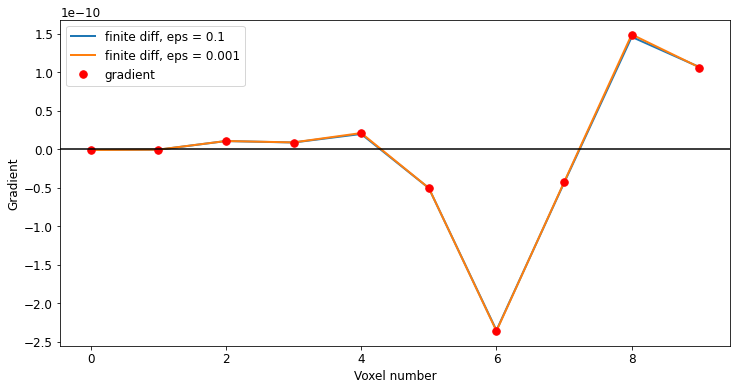

In [163]:
#test
# Plot diff btw gradient and finite difference 

%matplotlib inline
standard_plot(w=12,h=6,fontsize=12)
for i,fd in enumerate(fd_v):
    plt.plot(fd,'-',lw=2,label=f'finite diff, eps = {eps_v[i]}')
plt.plot(analytical_grad,'.',c='r',markersize=15,label='gradient')
plt.xlabel('Voxel number')
plt.ylabel('Gradient')
ax=plt.gca()
ax.axhline(0,c='k')
plt.legend()
plt.show()

## Reshaping test

In [62]:
np.random.seed(42)
N=10
resh_in = np.random.random((N**3,3))
print('Shape in = ',resh_in.shape)
print(resh_in[0:2,:])

### --------------- Forward pass: -------------------------

# Step 1
q, disp = compute_displacement(resh_in,250,10)

# Step 3 - reshaping initial pos and displacement
# not sure why order='C' is working here... not sure if it matters... could change it below
q_reshaped = np.reshape(q.T, (3,N,N,N), order='C') #output shape: (3, N, N, N)
dis_in = np.reshape(disp.T, (3,N,N,N), order='C') #output shape: (3, N, N, N)
dis_out = dis_in

# Step 10 - convert displacement into positions
pos = dis_out + q_reshaped

# Step 12 - reshape positions 
pos_out = pos.reshape(3,N**3,order='C').T #output shape: (N^3, 3)

### --------------- GO BACK: -------------------------

# reverse getDensityFinal
ag = pos_out 

# reverse step 11
ag = np.reshape(ag.T, (3,N,N,N), order='C')

# reverse step 3
ag_pos = ag.reshape(3,N**3,order='C').T
print('Shape out = ',ag_pos.shape)
print(ag_pos[0:2,:])

Shape in =  (1000, 3)
[[0.37454012 0.95071431 0.73199394]
 [0.59865848 0.15601864 0.15599452]]
Shape out =  (1000, 3)
[[0.37454012 0.95071431 0.73199394]
 [0.59865848 0.15601864 0.15599452]]


# Integrate emu-model from Drew into BORG 

In [ ]:
# Todo:
# 1. compute_displacement much faster if we store q_v and n_v = [n1,...,nN^3]